In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor

In [2]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')    ; cowpea['crop']   = 'cowpea'
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')      ; maize['crop']    = 'maize'
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')        ; rice['crop']     = 'rice'
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea'); chickpea['crop'] = 'chickpea'
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')  ; mustard['crop']  = 'mustard'

In [10]:
data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)

In [11]:
clf = LocalOutlierFactor(n_neighbors=20, p=2)

new_data = []
org_cols = data.columns
for i, outlier_label in enumerate(clf.fit_predict(data[['GSR', 'CT']])):
    if outlier_label==1:
        new_data.append(data.iloc[i,:])
data = pd.DataFrame(new_data, columns=org_cols)

In [12]:
data.loc[:, 'Time'] = data.loc[:, 'Time'].apply(lambda x: x.hour)
data.loc[:, 'timesin'] = np.sin(data.loc[:, 'Time'] * (2 * np.pi) / 12)
data.loc[:, 'timecos'] = np.cos(data.loc[:, 'Time'] * (2 * np.pi) / 12)

In [13]:
df = pd.get_dummies(data[['crop']])
data = pd.concat([df, data], axis=1)

In [14]:
feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
X = data[feature_cols]
y = data['Rn']

In [15]:
data.columns

Index(['crop_chickpea', 'crop_cowpea', 'crop_maize', 'crop_mustard',
       'crop_rice', 'Date', 'Time', 'GSR', 'CT', 'Rn', 'crop', 'ST_5cm',
       'ST_10cm', 'ST_15cm', 'timesin', 'timecos'],
      dtype='object')

<AxesSubplot:xlabel='GSR', ylabel='Rn'>

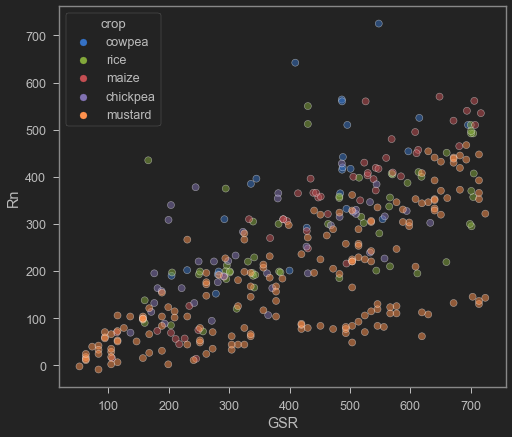

In [20]:
sns.scatterplot(x='GSR', y='Rn', data=data, hue='crop', alpha=0.5)

In [29]:
new_data['crop']

0       cowpea
1       cowpea
4       cowpea
5       cowpea
6       cowpea
        ...   
368    mustard
369    mustard
370    mustard
371    mustard
372    mustard
Name: crop, Length: 298, dtype: object

In [44]:
new_data = data[(data['GSR']<300) | (data['Rn']>150)]
new_data = new_data[(new_data['Rn']<500) | (new_data['crop']!='cowpea')]
new_data = new_data[(new_data['Rn']<400) | (new_data['GSR']>500) | (new_data['crop']!='rice')]
new_data = new_data[(new_data['Rn']<300) | (new_data['GSR']>375)]
# new_data = new_data[(new_data['Rn']>90) | (new_data['GSR']<150) | (new_data['crop']!='mustard')]

<AxesSubplot:xlabel='GSR', ylabel='Rn'>

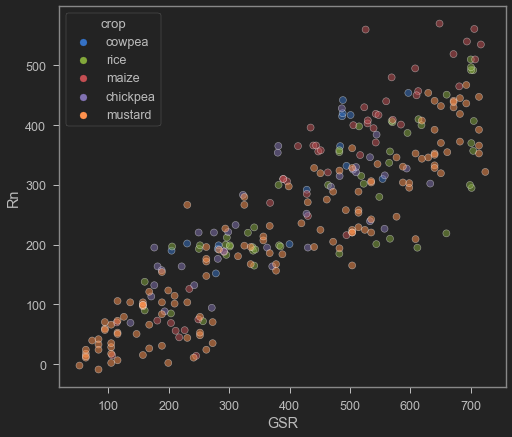

In [45]:
sns.scatterplot(x='GSR', y='Rn', data=new_data, hue='crop', alpha=0.5)